In [1]:
# Import libraries

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
% matplotlib inline
import pandas as pd

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import time
import requests
import tarfile
import os


!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd


Using TensorFlow backend.


Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
datalab


In [0]:
def dataextract(url):
  r = requests.get(url, allow_redirects=True)
  open('objdet', 'wb').write(r.content)
  tar = tarfile.open('objdet', "r:*")
  tar.extractall()
  tar.close()
  os.remove('objdet')

In [3]:
#get and extract dataset
dataextract('http://bit.ly/udacity-annoations-crowdai')  
print('done')
dataextract('http://bit.ly/udacity-annotations-autti') 
print('done')

done
done


In [4]:
## Get path where files are to be stored


df_files1 = pd.read_csv('object-detection-crowdai/labels.csv', header=0)
df_vehicles1 = df_files1[(df_files1['Label']=='Car') | (df_files1['Label']=='Truck')].reset_index()
df_vehicles1 = df_vehicles1.drop('index', 1)
df_vehicles1['File_Path'] =  'object-detection-crowdai/' +df_vehicles1['Frame']
df_vehicles1 = df_vehicles1.drop('Preview URL', 1)

df_vehicles1.tail()

df_files2 = pd.read_csv('object-dataset/labels.csv', header=None, names=['Frame',  'xmin', 'xmax', 'ymin','ymax', 'ind', 'Label', 'RM'], delim_whitespace=True)
#df_files2.columns= ['Frame',  'xmin', 'xmax', 'ymin','ymax', 'ind', 'Label']
df_vehicles2 = df_files2[(df_files2['Label']=='car') | (df_files2['Label']=='truck')].reset_index()
df_vehicles2 = df_vehicles2.drop('index', 1)
df_vehicles2 = df_vehicles2.drop('RM', 1)
df_vehicles2 = df_vehicles2.drop('ind', 1)
df_vehicles2['File_Path'] = 'object-dataset/' +df_vehicles2['Frame']

df_vehicles = pd.concat([df_vehicles1, df_vehicles2]).reset_index()
df_vehicles = df_vehicles.drop('index', 1)
df_vehicles.columns =['File_Path','Frame','Label','ymin','xmin','ymax','xmax']

s = len(df_vehicles)
a = int(0.8*s)-1
b = int(0.9*s)

train_set = df_vehicles[0:a].reset_index(drop=True)
valid_set = df_vehicles[a:b].reset_index(drop=True)
test_set  = df_vehicles[b:].reset_index(drop=True)
print(s)
test_set.tail()

130680


,File_Path,Frame,Label,ymin,xmin,ymax,xmax
13063,object-dataset/1478901536388465963.jpg,1478901536388465963.jpg,car,552,1048,748,1348
13064,object-dataset/1478901536960505700.jpg,1478901536960505700.jpg,car,606,0,780,142
13065,object-dataset/1478901536960505700.jpg,1478901536960505700.jpg,car,604,146,692,246
13066,object-dataset/1478901536960505700.jpg,1478901536960505700.jpg,car,582,710,618,800
13067,object-dataset/1478901536960505700.jpg,1478901536960505700.jpg,car,546,896,790,1228


In [0]:
def get_image_name(df,ind,size=(640,300)):
    # Get image and bounding boxes by filepath
    
    file_name = df['File_Path'][ind]
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    
    #resize image for the neural net
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,size)
    name_str = file_name.split('/')
    name_str = name_str[-1]
    bb_boxes = df[df['Frame'] == name_str].reset_index()
    img_size_post = np.shape(img)
    
    #resize bounding boxes
    bb_boxes['xmin'] = np.round(bb_boxes['xmin']/img_size[1]*img_size_post[1])
    bb_boxes['xmax'] = np.round(bb_boxes['xmax']/img_size[1]*img_size_post[1])
    bb_boxes['ymin'] = np.round(bb_boxes['ymin']/img_size[0]*img_size_post[0])
    bb_boxes['ymax'] = np.round(bb_boxes['ymax']/img_size[0]*img_size_post[0])
    bb_boxes['Area'] = (bb_boxes['xmax']- bb_boxes['xmin'])*(bb_boxes['ymax']- bb_boxes['ymin']) 
    return name_str,img,bb_boxes

def get_mask_seg(img,bb_boxes_f):
    
    #get mask based on the bounding boxes
    img_mask = np.zeros_like(img[:,:,0])
    for i in range(len(bb_boxes_f)):
        bb_box_i = [bb_boxes_f.iloc[i]['xmin'],bb_boxes_f.iloc[i]['ymin'],
                bb_boxes_f.iloc[i]['xmax'],bb_boxes_f.iloc[i]['ymax']]
        img_mask[int(bb_box_i[1]):int(bb_box_i[3]),int(bb_box_i[0]):int(bb_box_i[2])]= 1.
        img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    return img_mask

In [0]:
#set sizes
train_size = len(train_set) - 1
valid_size = len(valid_set) - 1
test_size  = len(test_set) - 1

#Image size
img_rows = 640
img_cols = 960

#### Training generator, generates augmented images
def generate_train_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(train_size)
            name_str,img,bb_boxes = get_image_name(train_set,i_line,
                                                   size=(img_cols, img_rows))
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks
        
        
#### Validation generator
def generate_validation_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(valid_size)
            name_str,img,bb_boxes = get_image_name(valid_set,i_line,
                                                   size=(img_cols, img_rows))
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks
        
#### Testing generator
def generate_test_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(test_size)
            name_str,img,bb_boxes = get_image_name(test_set,i_line,
                                                   size=(img_cols, img_rows))
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks

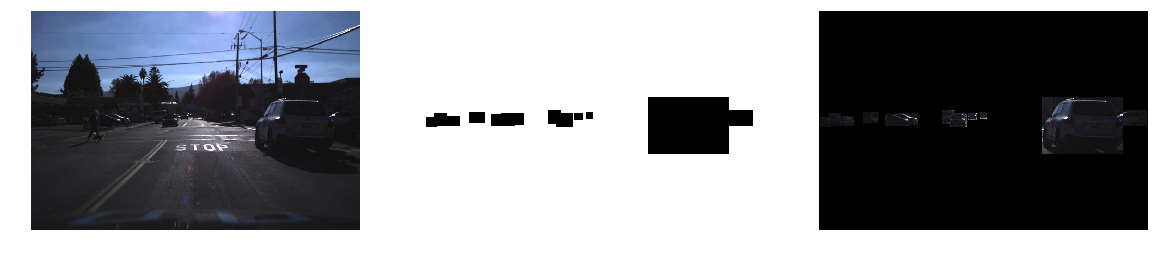

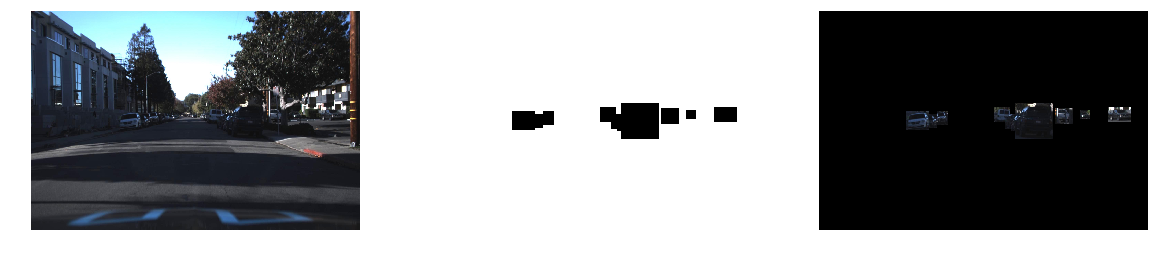

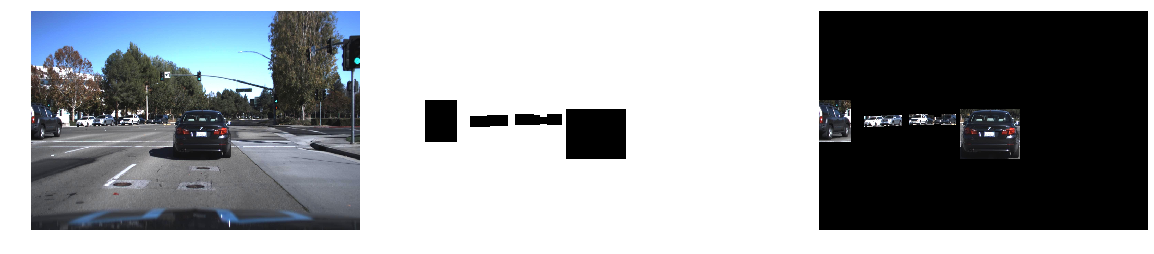

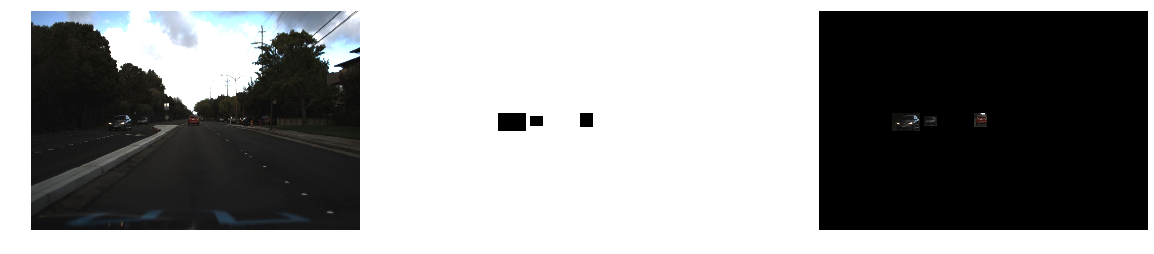

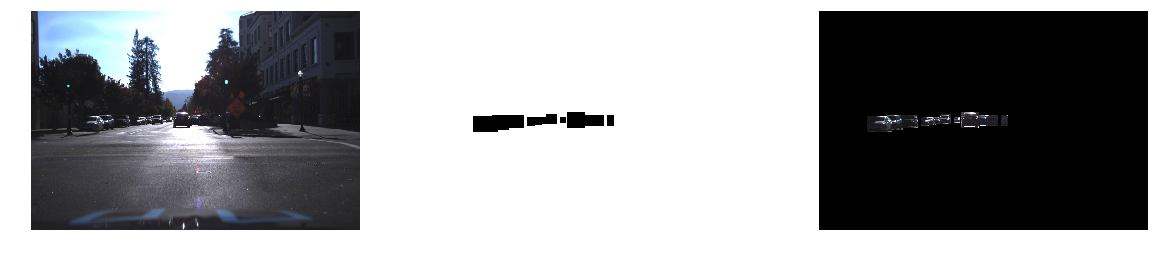

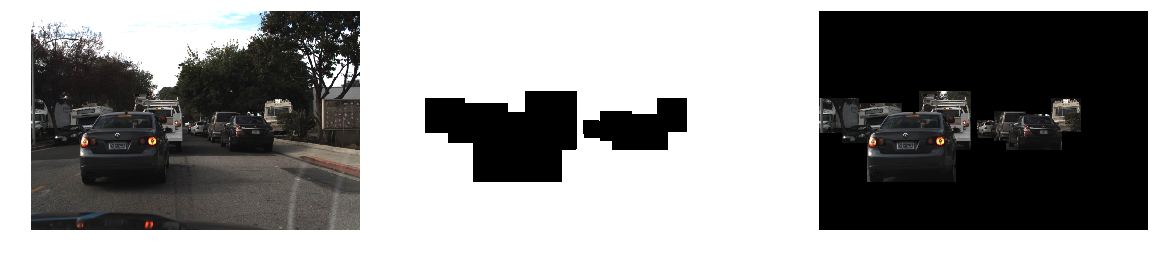

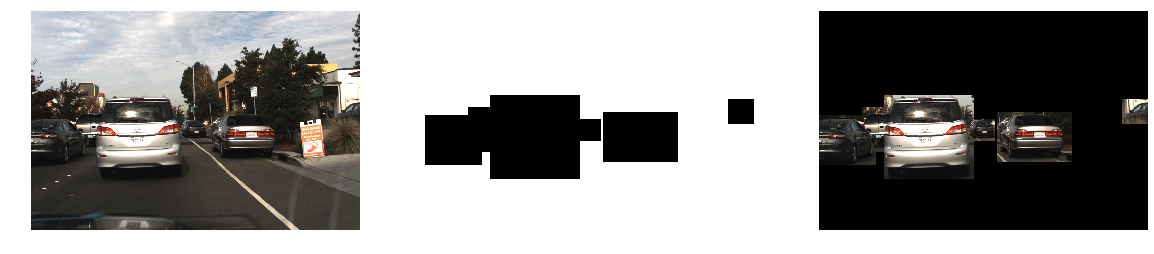

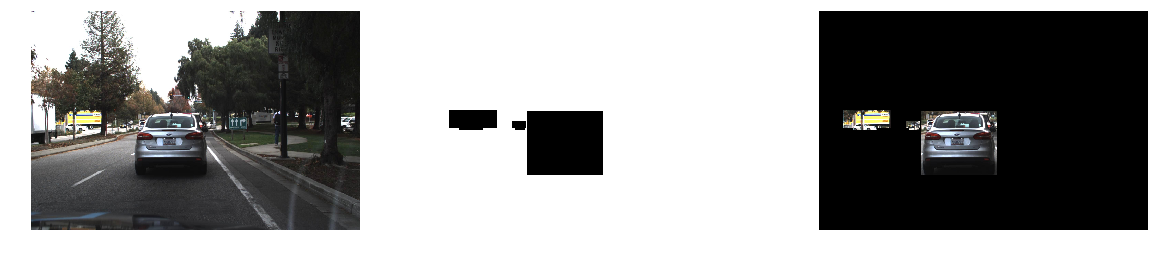

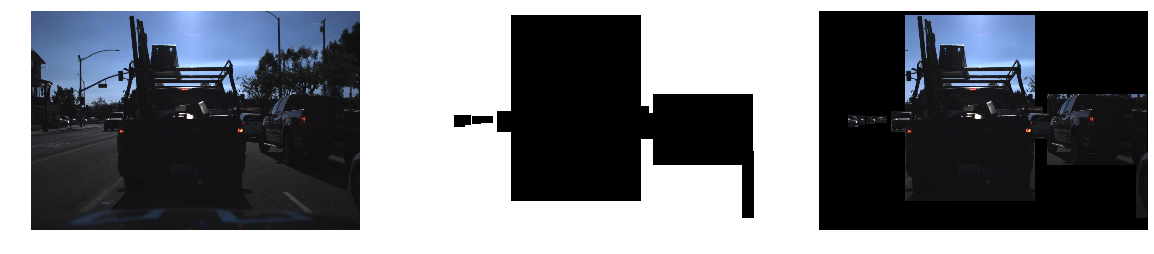

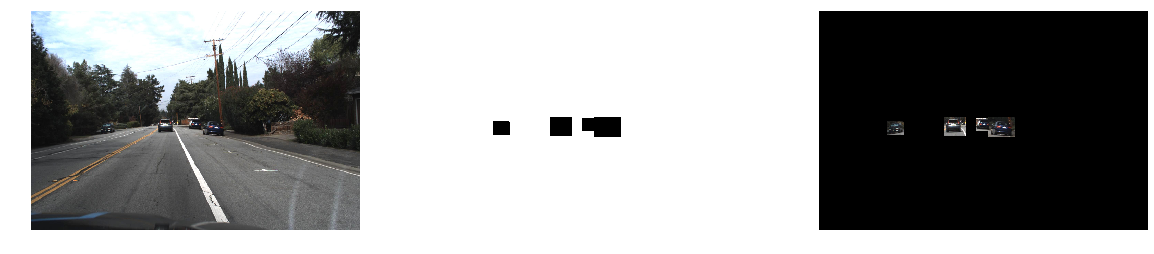

In [7]:
training_gen = generate_train_batch(df_vehicles,10)
batch_img,batch_mask = next(training_gen)
### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

In [0]:
# IOU or dice coeff calculation
smooth = 1.

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [0]:
### Defining a small Unet

def get_small_unet():
    inputs = Input((img_rows, img_cols,3))
    
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [0]:
#create model
model = get_small_unet()
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [0]:
#model summary
model.summary()

In [12]:
#get a pretrained network from the original source
load_pretrained = False
if load_pretrained == True:
  r = requests.get('https://github.com/vxy10/p5_VehicleDetection_Unet/raw/master/model_segn_small_0p72.h5', allow_redirects=True)
  open('model_segn_small_0p72.h5', 'wb').write(r.content)
  model.load_weights("model_segn_small_0p72.h5")
  
  
#1WLUSlmpHffjQuJQTKTG2vSiXKzFvgNiV
load_my_Modelm = True
if(load_my_Modelm == True):
    gdd.download_file_from_google_drive(file_id='1WLUSlmpHffjQuJQTKTG2vSiXKzFvgNiV', dest_path='./my_model.h5')
    model.load_weights("my_model.h5")

In [0]:
#training and validation generators
training_gen = generate_train_batch(df_vehicles,16)
validation_gen = generate_validation_batch(df_vehicles,16)

In [17]:
history = model.fit_generator(training_gen, validation_data=validation_gen, validation_steps= 5, steps_per_epoch=40, epochs=20)

Epoch 1/20
40/40 [==============================] - 78s 2s/step - loss: -0.7533 - IOU_calc: 0.7533 - val_loss: -0.6950 - val_IOU_calc: 0.6950
Epoch 2/20
40/40 [==============================] - 77s 2s/step - loss: -0.7555 - IOU_calc: 0.7555 - val_loss: -0.6998 - val_IOU_calc: 0.6998
Epoch 3/20
40/40 [==============================] - 77s 2s/step - loss: -0.7687 - IOU_calc: 0.7687 - val_loss: -0.6980 - val_IOU_calc: 0.6980
Epoch 4/20
40/40 [==============================] - 77s 2s/step - loss: -0.7699 - IOU_calc: 0.7699 - val_loss: -0.6444 - val_IOU_calc: 0.6444
Epoch 5/20
40/40 [==============================] - 77s 2s/step - loss: -0.7476 - IOU_calc: 0.7476 - val_loss: -0.7239 - val_IOU_calc: 0.7239
Epoch 6/20
27/40 [===================>..........] - ETA: 23s - loss: -0.7493 - IOU_calc: 0.7493

40/40 [==============================] - 77s 2s/step - loss: -0.7495 - IOU_calc: 0.7495 - val_loss: -0.7130 - val_IOU_calc: 0.7130
Epoch 7/20
40/40 [==============================] - 77s 2s/step - loss: -0.7604 - IOU_calc: 0.7604 - val_loss: -0.7040 - val_IOU_calc: 0.7040
Epoch 8/20
40/40 [==============================] - 77s 2s/step - loss: -0.7681 - IOU_calc: 0.7681 - val_loss: -0.7219 - val_IOU_calc: 0.7219
Epoch 9/20
40/40 [==============================] - 77s 2s/step - loss: -0.7678 - IOU_calc: 0.7678 - val_loss: -0.6847 - val_IOU_calc: 0.6847
Epoch 10/20
40/40 [==============================] - 77s 2s/step - loss: -0.7676 - IOU_calc: 0.7676 - val_loss: -0.7404 - val_IOU_calc: 0.7404
Epoch 11/20
32/40 [=======================>......] - ETA: 14s - loss: -0.7599 - IOU_calc: 0.7599

40/40 [==============================] - 77s 2s/step - loss: -0.7677 - IOU_calc: 0.7677 - val_loss: -0.7447 - val_IOU_calc: 0.7447
Epoch 12/20
40/40 [==============================] - 77s 2s/step - loss: -0.7703 - IOU_calc: 0.7703 - val_loss: -0.6873 - val_IOU_calc: 0.6873
Epoch 13/20
40/40 [==============================] - 77s 2s/step - loss: -0.7655 - IOU_calc: 0.7655 - val_loss: -0.6462 - val_IOU_calc: 0.6462
Epoch 14/20
40/40 [==============================] - 77s 2s/step - loss: -0.7736 - IOU_calc: 0.7736 - val_loss: -0.6991 - val_IOU_calc: 0.6991
Epoch 15/20
40/40 [==============================] - 77s 2s/step - loss: -0.7805 - IOU_calc: 0.7805 - val_loss: -0.7233 - val_IOU_calc: 0.7233
Epoch 16/20
32/40 [=======================>......] - ETA: 14s - loss: -0.7637 - IOU_calc: 0.7637

40/40 [==============================] - 77s 2s/step - loss: -0.7681 - IOU_calc: 0.7681 - val_loss: -0.7225 - val_IOU_calc: 0.7225
Epoch 17/20
40/40 [==============================] - 77s 2s/step - loss: -0.7881 - IOU_calc: 0.7881 - val_loss: -0.7248 - val_IOU_calc: 0.7248
Epoch 18/20
40/40 [==============================] - 77s 2s/step - loss: -0.7747 - IOU_calc: 0.7747 - val_loss: -0.7126 - val_IOU_calc: 0.7126
Epoch 19/20
40/40 [==============================] - 77s 2s/step - loss: -0.7734 - IOU_calc: 0.7734 - val_loss: -0.7434 - val_IOU_calc: 0.7434
Epoch 20/20
40/40 [==============================] - 77s 2s/step - loss: -0.7862 - IOU_calc: 0.7862 - val_loss: -0.7201 - val_IOU_calc: 0.7201


In [0]:
#save model
model.save_weights('my_model_final.h5', overwrite=True)

In [21]:
#export model to google drive
auth.authenticate_user()
drive_service = build('drive', 'v3')


file_metadata = { 'name': 'my_model_final.h5', 'mimeType': 'media' }
media = MediaFileUpload('./my_model_final.h5', mimetype='text/plain', resumable=True)
created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1WLUSlmpHffjQuJQTKTG2vSiXKzFvgNiV


In [0]:
#plot the history of training
plt.figure(figsize=(20,10))
plt.plot(history.history['IOU_calc'])
plt.plot(history.history['val_IOU_calc'])
plt.title('model IOU_calc vs val_IOU_calc')
plt.xlabel('epoch')
plt.legend(['IOU_calc', 'val_IOU_calc'], loc='upper left')
plt.show()


In [0]:
testing_gen = generate_test_batch(df_vehicles,20)
batch_img,batch_mask = next(testing_gen)

In [62]:
calc_time = time.time()
pred_all= model.predict(batch_img)
calc_time = time.time() - calc_time
print(calc_time)


0.9700288772583008


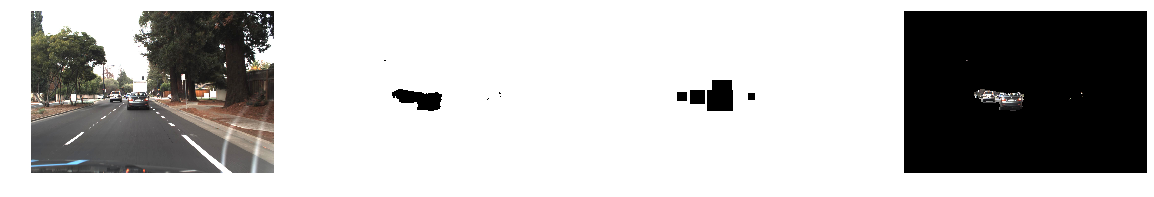

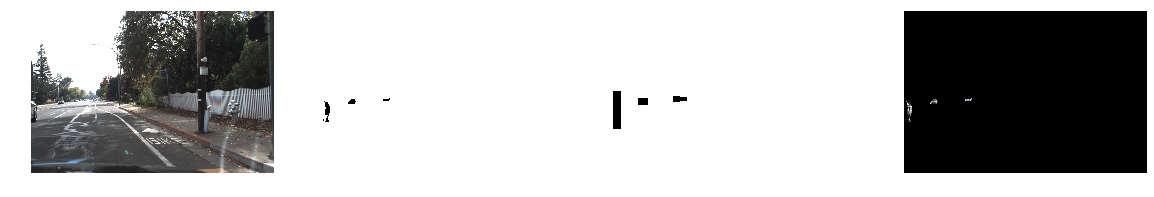

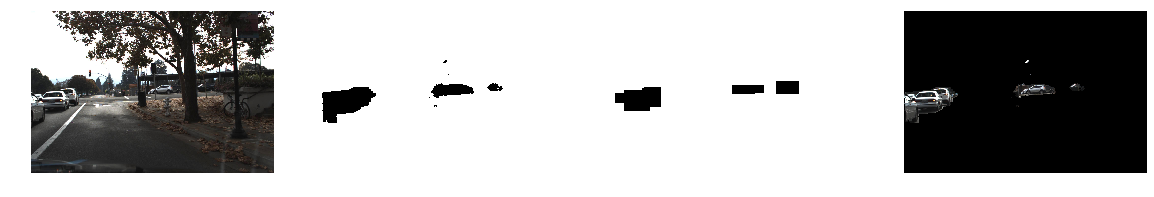

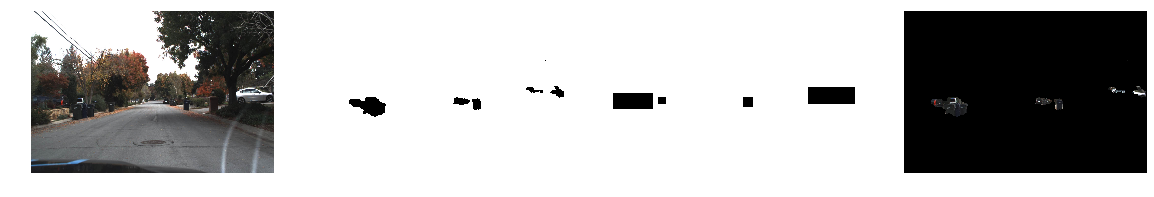

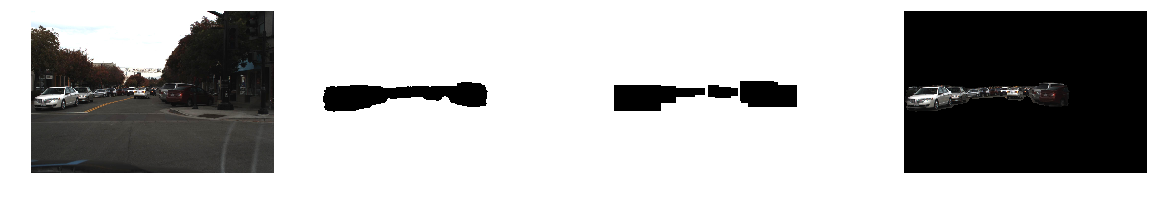

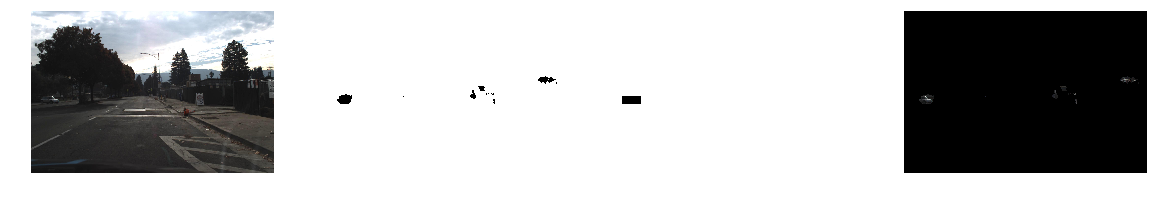

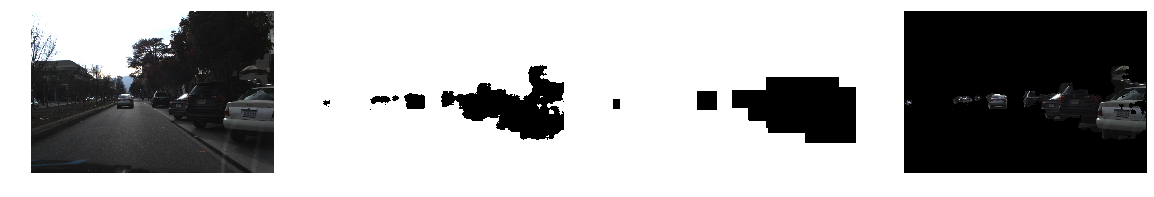

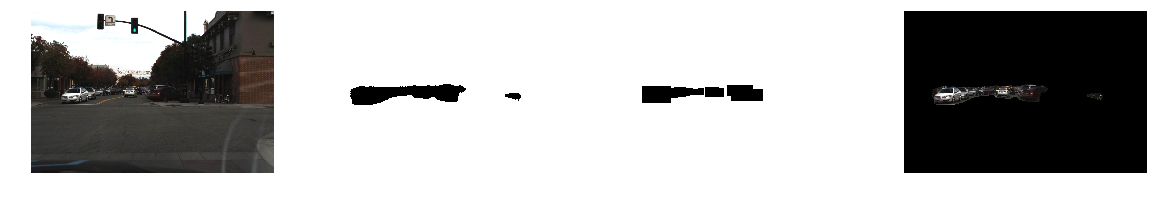

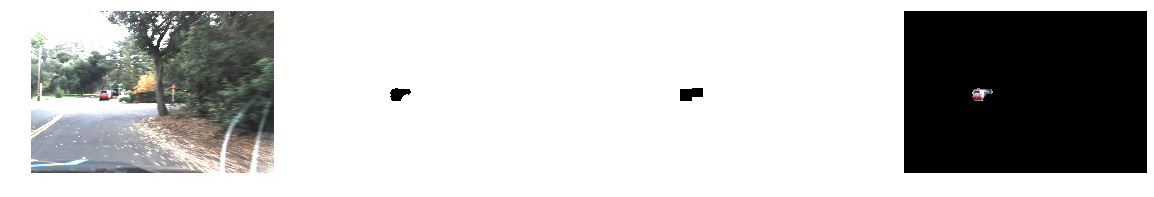

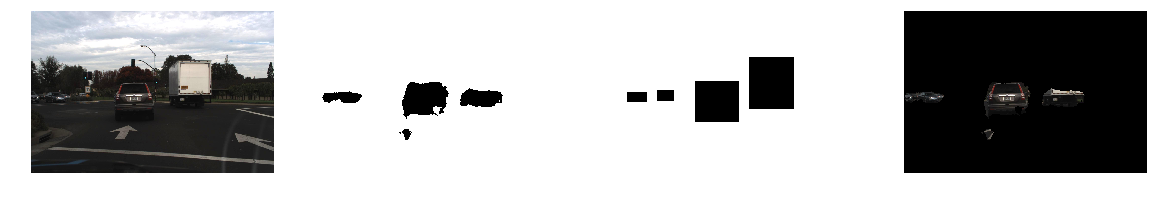

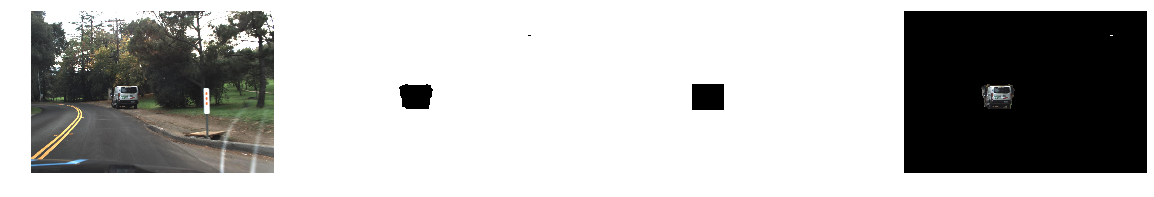

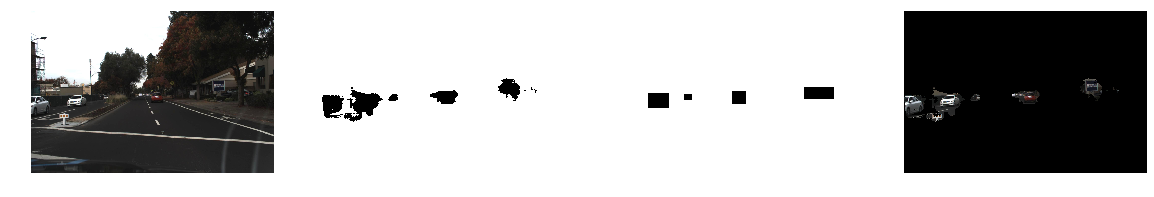

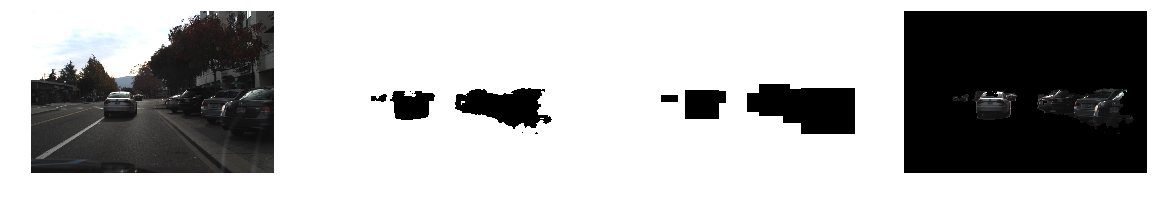

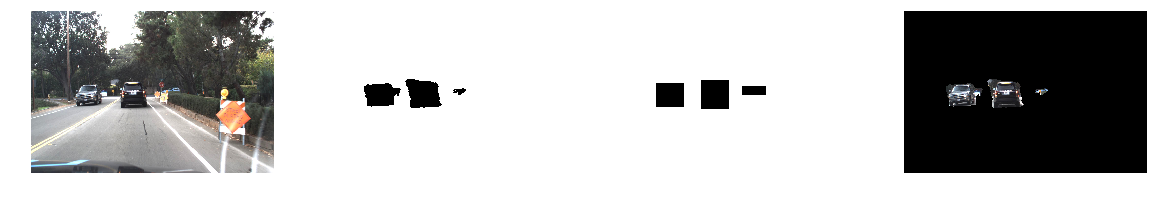

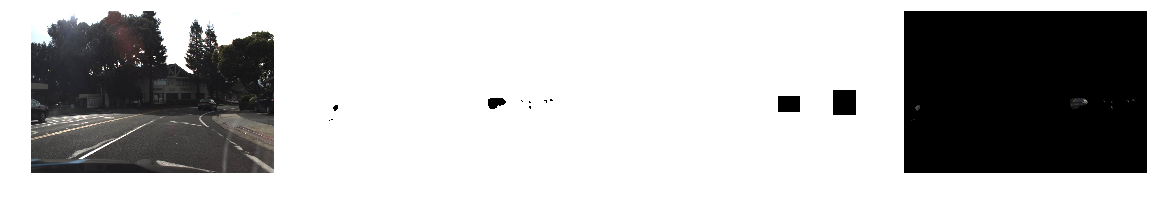

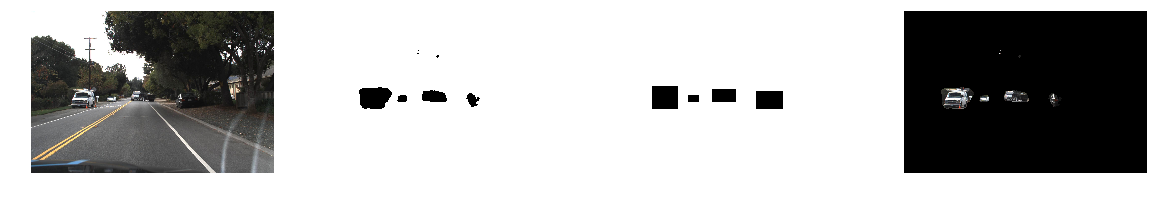

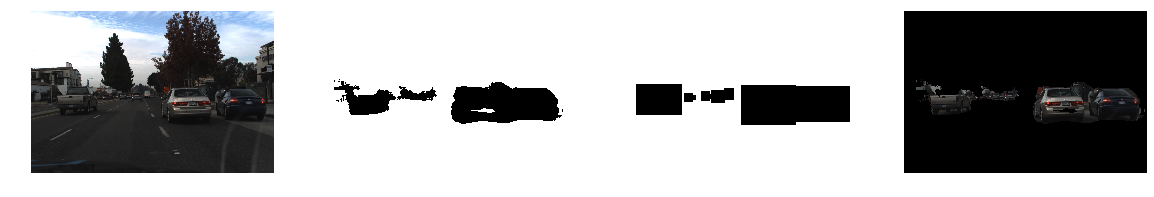

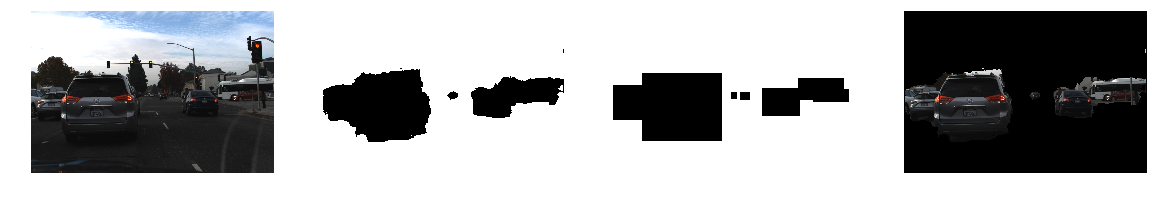

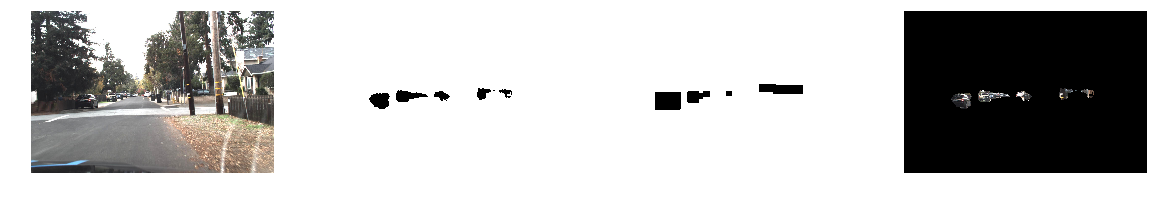

In [63]:


### Plotting generator output
for i in range(batch_img.shape[0]-1):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(pred_all[i],dtype=np.uint8)
    im_true = np.array(batch_mask[i],dtype=np.uint8)
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(im_true[:,:,0])
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();



In [0]:
def predict_image(img):
  img = cv2.resize(img,(img_cols, img_rows))
  img_r = np.reshape(img,(1,img_rows, img_cols,3))
  pred = model.predict(img_r)
  img  = np.array(img,dtype= np.uint8)
  img_pred = np.array(255*pred[0],dtype=np.uint8)
  heatmap = img_pred[:,:,0]
  img_cut = cv2.bitwise_and(img,img,mask = heatmap)
  dst = cv2.addWeighted(img,0.2,img_cut,0.8,0)
  return dst

In [83]:
!rm gta_footage.mp4
# GTA5: 1j9pchx_BffFgH7rJEFrnrX4ecn5c8vqz
gdd.download_file_from_google_drive(file_id='1j9pchx_BffFgH7rJEFrnrX4ecn5c8vqz',
                                    dest_path='./gta_footage.mp4')

!rm drone_footage.mp4
# drone: 157R4ASuP3xJIQ8kysmYo_oMA3vFbHkni
gdd.download_file_from_google_drive(file_id='157R4ASuP3xJIQ8kysmYo_oMA3vFbHkni',
                                    dest_path='./drone_footage.mp4')
!ls

datalab		   gta_footage.mp4    my_model.h5     object-detection-crowdai
drone_footage.mp4  my_model_final.h5  object-dataset  output_gta.webm


In [0]:
cap = cv2.VideoCapture('gta_footage.mp4')
width_o  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height_o = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps      = int(cap.get(cv2.CAP_PROP_FPS))
length   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(width_o, height_o, length)

count = 0

out = cv2.VideoWriter('output_gta.webm',cv2.VideoWriter_fourcc('V','P','8','0'), fps, (960, 640))
for i in range(length):
  _, frame = cap.read()
  img = predict_image(frame)
  out.write(img)
  print(count)
  count = count + 1
  
cap.release()
out.release()
print("done")

In [79]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

file_metadata = {
  'name': 'output_gta.webm',
  'mimeType': 'media'
}
media = MediaFileUpload('./output_gta.webm', 
                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1xBq-zuRM2LFUzWZik1NIyn0ox1YuwfWC


In [0]:
cap = cv2.VideoCapture('drone_footage.mp4')
width_o  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height_o = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps      = int(cap.get(cv2.CAP_PROP_FPS))
length   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(width_o, height_o, length)

count = 0

out = cv2.VideoWriter('output_drone.webm',cv2.VideoWriter_fourcc('V','P','8','0'), fps, (960, 640))
for i in range(length):
  _, frame = cap.read()
  img = predict_image(frame)
  out.write(img)
  print(count)
  count = count + 1
  
cap.release()
out.release()
print("done")

In [85]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

file_metadata = {
  'name': 'output_drone.webm',
  'mimeType': 'media'
}
media = MediaFileUpload('./output_drone.webm', 
                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1oaKUA0ERbVwPka1Bp5t3u7JHT7I1xZT_
